In [1]:
from sqlalchemy import create_engine
import pandas as pd
from collections import Counter
import re

db_string = 'postgresql://localhost/postgres'

db = create_engine(db_string)

In [2]:
sql = '''SELECT * 
         FROM artworks'''

In [3]:
result_set = pd.read_sql(sql, db)

In [4]:
artworks_df = pd.DataFrame(result_set)

In [5]:
artworks_df.head()

,title,artist,artistbio,nationality,begindate,enddate,gender,date,medium,dimensions,...,circumference,diameter,height,length,weight,width,seatheight,duration,depth,constituentid
0,Exposition - January 1898,Cause,(French),(French),(0),(0),(),1898,Poster,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,1040
1,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",...,NaN,NaN,49.0,NaN,NaN,169.0,None,NaN,None,6210
2,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",...,NaN,NaN,41.0,NaN,NaN,30.0,None,NaN,None,7470
3,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",...,NaN,NaN,34.0,NaN,NaN,32.0,None,NaN,None,7605
4,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",...,NaN,NaN,51.0,NaN,NaN,51.0,None,NaN,None,7056


In [6]:
artworks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138185 entries, 0 to 138184
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   title            138146 non-null  object 
 1   artist           136876 non-null  object 
 2   artistbio        132156 non-null  object 
 3   nationality      136876 non-null  object 
 4   begindate        136876 non-null  object 
 5   enddate          136876 non-null  object 
 6   gender           136876 non-null  object 
 7   date             135971 non-null  object 
 8   medium           128450 non-null  object 
 9   dimensions       128291 non-null  object 
 10  creditline       135754 non-null  object 
 11  accessionnumber  138185 non-null  object 
 12  classification   138185 non-null  object 
 13  department       138185 non-null  object 
 14  dateacquired     131051 non-null  object 
 15  cataloged        138185 non-null  object 
 16  objectid         138185 non-null  int6

## Cleaning Up Rows

Clean up rows:
- artistbio
- nationality
- begindate
- enddate
- gender
- date

In [7]:
# artistbio
# if-else in lambda statement allows me to replace NoneTypes with ''
artworks_df['artistbio'] = artworks_df['artistbio'].apply(lambda x: (x.replace('(', '').replace(')', '')) if x is not None else '')

In [8]:
# nationality
artworks_df['nationality'] = artworks_df['nationality'].apply(lambda x: (x.replace('(', '').replace(')', '')) if x is not None else '')

def nationality_assign(string):
    if 'Nationality unknown' in string:
        return string
    
    elif ' ' in string:
        new_list = string.split(' ')
        new_list = [i.capitalize() for i in new_list]
        counter = Counter()
        for each in new_list:
            if each == '':
                continue
            else:
                counter[each] += 1
                
        if len(counter) > 1:
            if counter.most_common()[0][1] == counter.most_common()[1][1]:
                return str(counter.most_common()[0][0]).capitalize().replace('(', '').replace(')', '') + '/' + str(counter.most_common()[1][0]) 
            else:
                return str(counter.most_common()[0][0])
        elif len(counter) == 1:
            return str(list(counter)[0])
        else:
            return string
    else:
        return string.capitalize()
    
artworks_df['nationality'] = artworks_df['nationality'].apply(nationality_assign)

In [9]:
artworks_df['nationality'].value_counts()

American              59639
French                22813
German                 9607
                       6411
British                6029
                      ...  
American/Icelandic        1
Swiss/Sahrawi             1
Swedish/Irish             1
Yugoslav/American         1
                          1
Name: nationality, Length: 341, dtype: int64

In [10]:
# begindate

artworks_df['begindate'] = artworks_df['begindate'].apply(lambda x: x.replace('(', '').replace(')', '').replace(' ', ',') if x is not None else '')

# can have multiple begindates, will take only the first four numbers as the begindate. 
# If first character is 0 and string less than 4, then 0. 
# Elif first character is 0, but string greater than 4, skip the 0 and take the next 4 numbers.
# Else: first 4 numbers.

def clean_beginend_date(string):
    if ',' in string:
        new_list = string.split(',')
        int_list = [int(i) for i in new_list]
        return max(int_list)
    elif string is None or string == '':
        return None
    else:
        return int(string)
    
artworks_df['begindate'] = artworks_df['begindate'].apply(clean_beginend_date)

In [11]:
# enddate

artworks_df['enddate'] = artworks_df['enddate'].apply(lambda x: x.replace('(', '').replace(')', '').replace(' ', ',') if x is not None else '')

# can have multiple enddates. We will select the most recent enddate if there are multiple dates applied.

artworks_df['enddate'] = artworks_df['enddate'].apply(clean_beginend_date)

In [12]:
# gender
# there can be multiple genders for one artwork (collaboration)

artworks_df['gender'] = artworks_df['gender'].apply(lambda x: x.replace('(', '').replace(')', '').replace(' ', ',') if x is not None else '')

# to better assign genders, if there were more of one gender involved in an artwork, I assigned the majority gender as the main gender. 
def gender_assign(string):
    if ',' in string:
        new_list = string.split(',')
        new_list = [i.capitalize() for i in new_list]
        counter = Counter()
        for each in new_list:
            if each == '':
                continue
            else:
                counter[each] += 1
                
        if len(counter) > 1:
            if counter.most_common()[0][1] == counter.most_common()[1][1]:
                return 'Male/Female'
            else:
                return str(counter.most_common()[0][0])
    
    else:
        return string.capitalize()
      
    
artworks_df['gender'] = artworks_df['gender'].apply(gender_assign)

In [13]:
# date
# first four characters if > 4 
# Else: return string
# one of the dates has a .1-3 1987; .4 1990 format.

artworks_df['date'] = artworks_df['date'].fillna('')

def clean_dates(string):
    
    if string == '' or string == None:
        return string
    
    
    if string[0].isnumeric() and string[1].isnumeric() and string[2].isnumeric():
        new_string = ''
        for each in string[:4]:
            new_string += each
        return new_string
    
    if string[0].isnumeric() and string[1].isnumeric():
        new_string = ''
        for each in string[:-5:-1]:
            new_string += each
        return new_string[::-1]
        
    if string[0] == '.':
        cleaned = re.sub("[^0-9]", "", string)
        new_string = ''
        for each in cleaned[2:6]:
            new_string += each
        return new_string
    
    if 'dated' in string and ';' in string and ',' in string: # we will take the dates that come after 'dated'
        cleaned = re.sub("[^0-9]", "", string)
        new_string = ''
        for each in cleaned[:-5:-1]:
            new_string += each
        return new_string[::-1]
        
    if string[0] == 'c' and string[1] == '.':
        cleaned = re.sub("[^0-9]", "", string)
        new_string = ''
        for each in cleaned[:4]:
            new_string += each
        return new_string
    
    if string[0].isalpha():
        cleaned = re.sub("[^0-9]", "", string)
        new_string = ''
        for each in cleaned[:-5:-1]:
            new_string += each
        return new_string[::-1]

artworks_df['date'] = artworks_df['date'].apply(clean_dates)

In [14]:
# dimensions
# og dimension column has inches and centimeters. We only want to record the inches. 
# After further investigation, there are many different ways the MoMA dataset is handling the dimensions. Will leave as a string for now.
'''
from fractions import Fraction


artworks_df['dimensions'] = artworks_df['dimensions'].fillna('')

def clean_dimensions(string):
    if string == '' or string == None:
        return string
    
    elif string[0].isnumeric():
        split_string = string.replace('"', '').split('(')[0].split(' ')
        split_string = [float(Fraction(i)) for i in split_string if i != '' and i != 'x']
    
        if len(split_string) == 4:
            first = split_string[0] + split_string[1]
            second = split_string[2] + split_string[3]
            return first*second
        elif len(split_string) == 3:
            first = split_string[0]
            if split_string[1] < 1:
                first = first + split_string[1]
                second = split_string[2]
            else:
                second = split_string[1] + split_string[2]
            return first*second
        elif len(split_string) == 2:
            return split_string[0]*split_string[1]
        
    elif string[0] == 'E':
        cleaned = string.replace('"', '').split('(')[0].split(' ')
'''        

'\nfrom fractions import Fraction\n\n\nartworks_df[\'dimensions\'] = artworks_df[\'dimensions\'].fillna(\'\')\n\ndef clean_dimensions(string):\n    if string == \'\' or string == None:\n        return string\n    \n    elif string[0].isnumeric():\n        split_string = string.replace(\'"\', \'\').split(\'(\')[0].split(\' \')\n        split_string = [float(Fraction(i)) for i in split_string if i != \'\' and i != \'x\']\n    \n        if len(split_string) == 4:\n            first = split_string[0] + split_string[1]\n            second = split_string[2] + split_string[3]\n            return first*second\n        elif len(split_string) == 3:\n            first = split_string[0]\n            if split_string[1] < 1:\n                first = first + split_string[1]\n                second = split_string[2]\n            else:\n                second = split_string[1] + split_string[2]\n            return first*second\n        elif len(split_string) == 2:\n            return split_string[0]*sp

In [15]:
artworks_df['dimensions'] = artworks_df['dimensions'].fillna('')

In [16]:
artworks_df.to_sql('artworks_clean', db, if_exists='append', index = False)

## Visualizations

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [18]:
artworks_df.head()

,title,artist,artistbio,nationality,begindate,enddate,gender,date,medium,dimensions,...,circumference,diameter,height,length,weight,width,seatheight,duration,depth,constituentid
0,Exposition - January 1898,Cause,French,French,0.0,0.0,,1898,Poster,,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,1040
1,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,"Austrian, 1841–1918",Austrian,1841.0,1918.0,Male,1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",...,NaN,NaN,49.0,NaN,NaN,169.0,None,NaN,None,6210
2,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,"French, born 1944",French,1944.0,0.0,Male,1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",...,NaN,NaN,41.0,NaN,NaN,30.0,None,NaN,None,7470
3,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,"Austrian, 1876–1957",Austrian,1876.0,1957.0,Male,1903,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",...,NaN,NaN,34.0,NaN,NaN,32.0,None,NaN,None,7605
4,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,"French and Swiss, born Switzerland 1944",,1944.0,0.0,Male,1980,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",...,NaN,NaN,51.0,NaN,NaN,51.0,None,NaN,None,7056


In [22]:
# Most amount of artworks by an artist?

artworks_df['artist'].value_counts(ascending = False).head(20)

Eugène Atget                5050
Louise Bourgeois            3336
Unknown photographer        2810
Ludwig Mies van der Rohe    2645
Jean Dubuffet               1435
Lee Friedlander             1320
Pablo Picasso               1309
Marc Chagall                1161
Henri Matisse               1063
Pierre Bonnard               901
Frank Lloyd Wright           874
Lilly Reich                  823
George Maciunas              821
August Sander                750
Unknown Artist               671
Ben Kinmont                  665
Georges Rouault              631
Émile Bernard                630
Sol LeWitt                   619
Aristide Maillol             579
Name: artist, dtype: int64

In [32]:
# Most amount of artworks by nationality?

artworks_df['nationality'].value_counts().head(20)

American               59639
French                 22813
German                  9607
                        6411
British                 6029
Spanish                 3154
Italian                 2926
Russian                 2608
Japanese                2587
Swiss                   2230
Dutch                   1661
Belgian                 1470
Mexican                 1353
Nationality unknown     1158
Argentine               1025
Austrian                1006
Canadian                 895
Brazilian                827
Czech                    771
Colombian                760
Name: nationality, dtype: int64

## Do males overcompensate their artworks with larger sizes? ;)

In [94]:
# Largest painting? Found the area for each artwork using its filled in dimensions.

import math

def assign_size(row):
    if row['height'] and row['width'] and row['depth'] == None:
        return row['height']*row['width']
    elif row['height'] and row['width'] and row['depth']:
        return row['height']*row['width']*float(row['depth'])
    
    elif row['circumference'] and math.isnan(row['diameter']) or row['diameter'] and math.isnan(row['height']):
        return row['circumference']
    elif row['circumference'] and row['diameter'] and row['height']:
        return round(row['circumference']*row['height'] + 2*math.pi*(row['diameter']/2)**2, 2)
    elif row['circumference'] and row['height'] and row['length']:
        return round(row['circumference']*row['length'] + 2*math.pi*row['height']/2**2, 2)
        
    elif row['length'] and row['width'] and math.isnan(row['height']):
        return row['length']*row['width']
    elif row['length'] and row['width'] and row['height']:
        return row['length']*row['width']
    elif row['length'] and row['width'] and row['depth']:
        return row['length']*row['width']*float(row['depth'])
    elif row['length'] and row['diameter']:
        return round(math.pi*row['diameter']*row['length'] * 2*math.pi*(row['diameter']/2)**2, 2)
    else:
        return None
        

In [98]:
size = artworks_df.apply(assign_size, axis = 1)

In [99]:
artworks_df['size'] = size

In [126]:
artworks_df['dimensions'][122528]

"Installation: 164.04 × 39.37 × 13.12' (50 × 12 × 4 m)"

In [125]:
artworks_df.sort_values(by = ['size'], ascending = False).head(20)

,title,artist,artistbio,nationality,begindate,enddate,gender,date,medium,dimensions,...,diameter,height,length,weight,width,seatheight,duration,depth,constituentid,size
122528,"Untitled (Havana, 2000)",Tania Bruguera,"Cuban, born 1968",Cuban,1968.0,0.0,Female,2000,"Sugar cane bagasse, video (black and white, si...",Installation: 164.04 × 39.37 × 13.12' (50 × 12...,...,NaN,5000.0,NaN,NaN,1200.0,None,NaN,400.0,48122,2.400000e+09
108275,Perth Amboy,Rachel Harrison,"American, born 1966",American,1966.0,0.0,Female,2001,"Cardboard, colored straws, chromogenic prints,...","Overall 15' x 41' 5"" x 59' 4"" (457.2 x 1262.4 ...",...,NaN,457.0,NaN,NaN,1262.0,None,NaN,1808.4836169672,7855,1.043014e+09
81019,Stasi City,"Louise Wilson, Jane Wilson","British, born 1967 British, born 1967",British,1967.0,0.0,None,1997,"Two videos (color, sound; 5 min.), four projec...",Overall: 18' x 35' x 35',...,NaN,549.0,NaN,NaN,1067.0,None,NaN,1066.8021,"26421, 26424",6.249145e+08
124190,"What It's Like, What It Is #3",Adrian Piper,"American, born 1948",American,1948.0,0.0,Female,1991,"Video Installation: Wood constructions, mirror...",Dimensions variable. \r\nInstallation: 216 × 3...,...,NaN,549.0,NaN,NaN,914.0,None,NaN,914.4018288037,7017,4.588340e+08
75152,Six,Tony Oursler,"American, born 1957",American,1957.0,0.0,Male,1996,"Six-channel video (color, sound), projectors, ...","Each sphere, approximately 18"" (45.7 cm) in di...",...,NaN,348.0,NaN,NaN,1034.0,None,NaN,853.4,7489,3.070806e+08
82654,Drunk,Gillian Wearing,"British, born 1963",British,1963.0,0.0,Female,1997,"Three-channel video (black and white, sound)",28:35 min. Dimensions variable. Approximately ...,...,NaN,396.0,NaN,NaN,1128.0,None,NaN,670.5613,8485,2.995317e+08
74828,Torqued Ellipse IV,Richard Serra,"American, born 1938",American,1938.0,0.0,Male,1998,Weatherproof steel,"12' 3"" x 26' 6"" x 32' 6"" (373.4 x 807.7 x 990....",...,NaN,373.0,NaN,26762.0,808.0,None,NaN,990.6,5349,2.985510e+08
98176,Just a bit more,Ranjani Shettar,"Indian, born 1977",Indian,1977.0,0.0,Female,2005,"Hand-molded beeswax, pigments, and thread dyed...",Overall 36’ x 24’ x 12’ (1097.3 x 731.5 x 365....,...,NaN,1097.0,NaN,NaN,732.0,None,NaN,365.7607315215,37577,2.937073e+08
87680,To Lift,Richard Serra,"American, born 1938",American,1938.0,0.0,Male,1967,Vulcanized rubber,"36"" x 6' 8"" x 60"" (91.4 x 200 x 152.4 cm)",...,NaN,9140.0,NaN,NaN,200.0,None,NaN,152.4003,5349,2.785877e+08
75116,Frontal Passage,James Turrell,"American, born 1943",American,1943.0,0.0,Male,1994,Light,"12' 10"" x 22' 6"" x 34' (391.2 x 685.8 x 1036.3...",...,NaN,391.0,NaN,NaN,686.0,None,NaN,1036.3,5981,2.779626e+08


In [143]:
plot_values = artworks_df['gender'].value_counts()

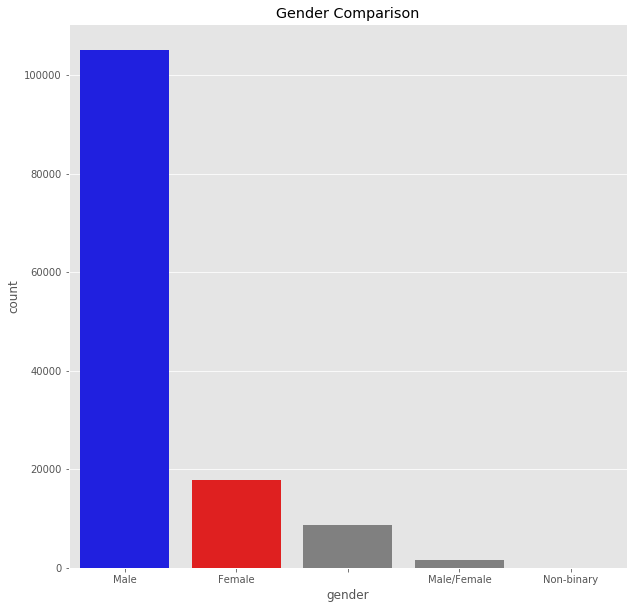

In [145]:
figure = plt.figure(figsize = (10,10))
plt.title('Gender Comparison')
clrs = ['blue' if x > 20000 else 'red' if 15000<x<20000 else 'grey' for x in plot_values]
sns.countplot(x = artworks_df['gender'], order = ['Male', 'Female', '', 'Male/Female', 'Non-binary'], color = 'grey', palette = clrs)

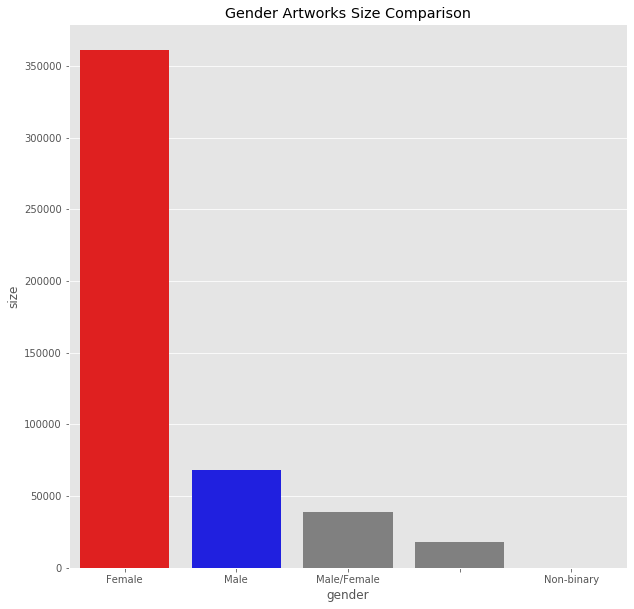

In [149]:
figure = plt.figure(figsize = (10,10))
plt.title('Gender Artworks Size Comparison')
clrs = ['red' if x > 100000 else 'blue' if 10000<x<75000 else 'grey' for x in plot_values]
sns.barplot(x = artworks_df['gender'], y = (artworks_df['size']), ci = None, order = ['Female', 'Male', 'Male/Female','', 'Non-binary'], palette = clrs);

Males do not have the larger size artworks! It seems women, by far, have the larger average artworks in the MoMA, despite the MoMA having more males than female artists.